In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.base import BaseEstimator, TransformerMixin

In [226]:
#Надстройки!
import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

In [227]:
# Надстройки Дарины

from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, KFold
from category_encoders import TargetEncoder

In [228]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [229]:
test_id = pd.read_csv('test.csv', usecols=['Id'])

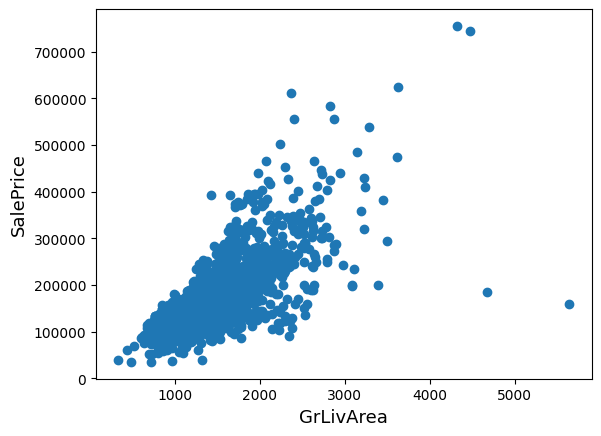

In [230]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()



In [231]:
# Удаляе выброcы
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [232]:
ntrain = train.shape[0]

In [233]:
X_train, y_train = train.drop('SalePrice', axis=1), train['SalePrice']

In [234]:
y_train1 = np.log1p(y_train)

In [235]:
X_train.shape, test.shape

((1457, 80), (1459, 80))

In [236]:
X_full = pd.concat([X_train, test], axis=0)

# Проверим размерность датасета X_train после присоединения test
print("Размерность X_full после присоединения test:", X_full.shape)

Размерность X_full после присоединения test: (2916, 80)


# Немного feature-ingineering

In [237]:
# Можно эти при3наки упростить до есть/нет
X_full['HasOpenPorch'] = (X_full['OpenPorchSF'] == 0) * 1
X_full['HasEnclosedPorch'] = (X_full['EnclosedPorch'] == 0) * 1
X_full['Has3SsnPorch'] = (X_full['3SsnPorch'] == 0) * 1
X_full['HasScreenPorch'] = (X_full['ScreenPorch'] == 0) * 1

# И вынести общую площадь крыльца
X_full['Total_porch_sf'] = (X_full['OpenPorchSF'] + X_full['3SsnPorch'] +
                              X_full['EnclosedPorch'] + X_full['ScreenPorch'] +
                              X_full['WoodDeckSF'])

In [238]:
# Бассеин можно оставить, но упростить до есть/нет
X_full['haspool'] = X_full['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

In [239]:
#Объединим год постройки и реконструкции
X_full['YrBltAndRemod'] = X_full['YearBuilt'] + X_full['YearRemodAdd']

In [240]:
# Добавляем общую площадь подвала, первого и второго этажей каждого дома
X_full['TotalSF'] = X_full['TotalBsmtSF'] + X_full['1stFlrSF'] + X_full['2ndFlrSF']
# Добавляем общую площадь ванных комнат
X_full['TotalBath'] = X_full['FullBath'] + X_full['HalfBath']

In [241]:
to_drop = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF', 'PoolArea', 'TotalBsmtSF', '1stFlrSF',
           '2ndFlrSF', 'FullBath', 'HalfBath', 'Utilities', 'PoolQC', 'Id']

In [242]:
X_full.drop(to_drop, axis=1, inplace=True)

In [243]:
X_full

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,SaleCondition,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,Total_porch_sf,haspool,YrBltAndRemod,TotalSF,TotalBath
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,Inside,Gtl,...,Normal,0,1,1,1,61,0,4006,2566.0,3
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,FR2,Gtl,...,Normal,1,1,1,1,298,0,3952,2524.0,2
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,Inside,Gtl,...,Normal,0,1,1,1,42,0,4003,2706.0,3
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,Corner,Gtl,...,Abnorml,0,0,1,1,307,0,3885,2473.0,1
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,FR2,Gtl,...,Normal,0,1,1,1,276,0,4000,3343.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,Inside,Gtl,...,Normal,1,1,1,1,0,0,3940,1638.0,2
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,Inside,Gtl,...,Abnorml,0,1,1,1,24,0,3940,1638.0,2
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,Inside,Gtl,...,Abnorml,1,1,1,1,474,0,3956,2448.0,1
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,Inside,Gtl,...,Normal,0,1,1,1,112,0,3984,1882.0,1


# Работа с пропусками в данных

In [244]:
#Количество пропусков
d1 = pd.DataFrame(data={'NaN_count': X_full.isna().sum()})
missing_data = d1[d1['NaN_count'] > 0]
missing_data = missing_data['NaN_count'].sort_values(ascending=False)

Text(0.5, 1.0, 'Доля пропущенных значений по каждому признаку')

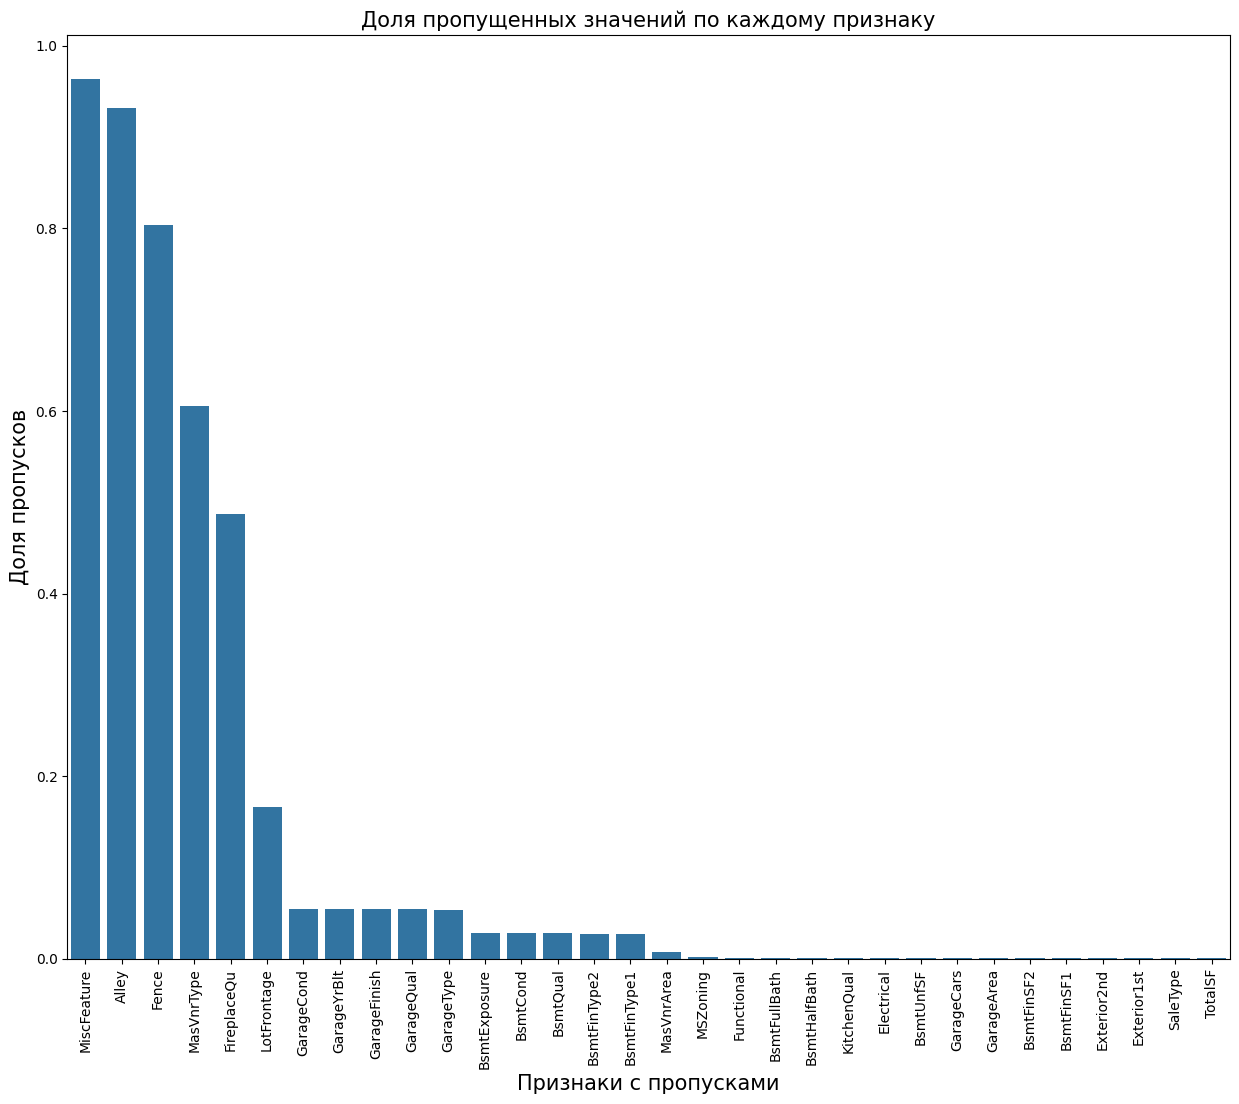

In [245]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x=missing_data.index, y=missing_data/X_full.shape[0])
plt.xlabel('Признаки с пропусками', fontsize=15)
plt.ylabel('Доля пропусков', fontsize=15)
plt.title('Доля пропущенных значений по каждому признаку', fontsize=15)



In [246]:
# #Из описания данных видно, что в некоторых столбцах  Nan означают не пропуск в данных, а отсутствие данного признака
# # IMPUTE
IMPUTE_FEATURES_ZEROS = ['MasVnrArea', 'GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea', 'GarageCars',
                         'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']
IMPUTE_FEATURES_NONE = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2',
                         'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType','Fence', 'Alley', 'MiscFeature', 'Exterior2nd', 'FireplaceQu']
IMPUTE_FEATURES_MODA = ['Electrical', 'MSZoning', 'Heating', 'HeatingQC', 'Functional', 'KitchenQual', 'Exterior1st', 'SaleType']
IMPUTE_FEATURES_LOTFR = ['Neighborhood', 'LotFrontage']
IMPUTE_FEATURES_MEAN = ['TotalSF']

In [247]:
from sklearn.base import BaseEstimator, TransformerMixin

class LotFrontageImputer(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None):
        # Вычисление медианы для каждого района и сохранение их в атрибуте объекта
        self.lotfrontage_medians_ = X.groupby('Neighborhood')['LotFrontage'].median()
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        # Заполнение пропущенных значений медианами, соответствующими районам
        X_copy['LotFrontage'] = X_copy.apply(lambda row: self.lotfrontage_medians_[row['Neighborhood']] if pd.isnull(row['LotFrontage']) else row['LotFrontage'], axis=1)
        return X_copy



In [248]:

# drop_features = ['Id'] # Здесь пока помечаю столбцы, которые будем удалять


my_imputer = ColumnTransformer(
    transformers = [
        # ('drop_features', 'drop', drop_features),
        ('num_imputer', SimpleImputer(strategy='constant', fill_value=0), IMPUTE_FEATURES_ZEROS),
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='NA'), IMPUTE_FEATURES_NONE),
        ('moda_imputer', SimpleImputer(strategy='most_frequent'), IMPUTE_FEATURES_MODA),
        ('lot_fr_imputer', LotFrontageImputer(), IMPUTE_FEATURES_LOTFR),
        ('neam_imputer', SimpleImputer(strategy='mean'), IMPUTE_FEATURES_MEAN)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)    

In [249]:
# X_full = my_imputer.fit_transform(X_full)

In [250]:
train = X_full[:ntrain]
test = X_full[ntrain:]

In [251]:
# определяем фичи для типов кодирования
ordinal_features = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 
'Foundation', 'BsmtQual', 'BsmtCond',  'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 
'KitchenQual','Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']


# Настройка one-hot кодирования
# onehot_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 
# 'LotConfig', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Heating', 'CentralAir', 'GarageType', 
# 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

target_features = ['Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 
'LotConfig', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Heating', 'CentralAir', 'GarageType', 
'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


# порядок категорий для ordinal_features
ordinal_categories = [
    ['Reg', 'IR1', 'IR2', 'IR3'],  # Порядок для LotShape
    ['Gtl', 'Mod', 'Sev'], # Порядок для LandSlope
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'],  # ExterQual 
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'],  # ExterCond
    ['PConc', 'CBlock', 'BrkTil', 'Stone', 'Wood', 'Slab'],  # Foundation
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],  # BsmtQual
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],  # BsmtCond
    ['Gd', 'Av', 'Mn', 'No', 'NA'],  # BsmtExposure
    ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], # BsmtFinType1
    ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], # BsmtFinType2
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'], # HeatingQC
    ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'], # Electrical 
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'], #  KitchenQual
    ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'], # Functional
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], # FireplaceQu
    ['Fin', 'RFn', 'Unf', 'NA'], # GarageFinish
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], # GarageQual
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], # GarageCond 
]

In [252]:
#  Закодируем данные
encoder = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
        # ('onehot', OneHotEncoder(sparse_output=False), onehot_features),
        ('target_encoder', TargetEncoder(), target_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out = False
)

In [253]:
# encoder.fit_transform(train, y_train)

In [254]:
preprocessor1 = Pipeline(
    [
        ('imputer', my_imputer),
        ('encoder', encoder)
    ]
)

In [255]:
# preprocessor1.fit_transform(train, y_train)

In [256]:
scaler = ColumnTransformer(
    transformers=[
        ('scaling_num_columns', StandardScaler(), preprocessor1.fit_transform(train, y_train).columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out = False
)

In [257]:
preprocessor2 = Pipeline(
    [
        ('preprocessor1', preprocessor1),
        ('scaler', scaler)
    ]
)

In [258]:
# preprocessor2.fit_transform(train, y_train)

In [259]:
preprocessor2.fit(train, y_train)

Pipeline(steps=[('preprocessor1',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['MasVnrArea',
                                                                    'GarageYrBlt',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'GarageArea',
                                                                    'GarageCars',
                                                                    'BsmtUnfSF',
                                                                    'BsmtFinSF2',
                                                                    'BsmtFinSF1']),
                                                                  ('cat_imputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 st...
       'BsmtFinSF2', 'BsmtFinSF1', 'LotFrontage', 'TotalSF', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'MiscVal', 'MoSold', 'YrSold',
       'HasOpenPorch', 'HasEnclosedPorch', 'Has3SsnPorch', 'HasScreenPorch',
       'Total_porch_sf', 'haspool', 'YrBltAndRemod', 'TotalBath'],
      dtype='object'))],
                                   verbose_feature_names_out=False))])

In [260]:
# joblib.dump(preprocessor2, 'preprocessor2.pkl')

In [261]:
# train = preprocessor2.fit_transform(train, y_train)

In [262]:
# test = preprocessor2.transform(test)

In [263]:
# lasso = Lasso(alpha=0.4)
# lasso.fit(preprocessor2.fit_transform(train, y_train), y_train)

# # Сортировка коэффициентов Lasso и выбор признаков для удаления
# corr = pd.Series(dict(zip(train.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=False)
# to_drop = corr[corr < 100].tail(40).index.to_list()


In [264]:

# Создаем собственный трансформер для удаления выбранных столбцов
class ColumnDroper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)

# Создание модели Lasso и её обучение
lasso = Lasso(alpha=0.4)
lasso.fit(preprocessor2.fit_transform(train, y_train), y_train)

# Сортировка коэффициентов Lasso и выбор признаков для удаления
corr = pd.Series(dict(zip(train.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=False)
to_drop = corr[corr < 100].tail(40).index.to_list()

# Итоговый пайплайн предобработки данных
final_preprocessing = Pipeline(
    [
        ('preprocessor2', preprocessor2),
        ('deliter', ColumnDroper(columns_to_drop=to_drop))
    ]
)


/home/vera/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.196e+11, tolerance: 9.202e+08
  model = cd_fast.enet_coordinate_descent(


In [265]:
final_preprocessing


Pipeline(steps=[('preprocessor2',
                 Pipeline(steps=[('preprocessor1',
                                  Pipeline(steps=[('imputer',
                                                   ColumnTransformer(remainder='passthrough',
                                                                     transformers=[('num_imputer',
                                                                                    SimpleImputer(fill_value=0,
                                                                                                  strategy='constant'),
                                                                                    ['MasVnrArea',
                                                                                     'GarageYrBlt',
                                                                                     'BsmtFullBath',
                                                                                     'BsmtHalfBath',
                                                                                     'GarageArea',
                                                                                     'GarageCars',
                                                                                     'BsmtUnfSF',
                                                                                     'BsmtFinSF2',
                                                                                     'BsmtFinSF1']),
                                                                                   ('cat_imputer'...
                                               'MiscFeature', 'LotFrontage',
                                               'LandContour', 'ExterQual',
                                               'Condition2', 'OverallCond',
                                               'TotalSF', 'MiscVal', 'BldgType',
                                               'Fireplaces', 'Alley',
                                               'Neighborhood', 'Heating',
                                               'BsmtFinType2', 'SaleCondition',
                                               'Total_porch_sf', 'MasVnrArea',
                                               'RoofMatl', 'PavedDrive',
                                               'MSZoning', 'Exterior1st',
                                               'CentralAir', 'Electrical',
                                               'KitchenAbvGr', 'BsmtFinSF2',
                                               'Street', 'Exterior2nd',
                                               'SaleType', ...]))])

In [266]:
# final_preprocessing.fit(train, y_train)

In [267]:
joblib.dump(final_preprocessing, 'final_preprocessing.pkl')

['final_preprocessing.pkl']

In [268]:
#Старая версия
# lasso = Lasso(alpha= 0.4)
# lasso.fit(train, y_train)
# corr = pd.Series(dict(zip(train.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=False)

# to_drop = corr[corr < 100].tail(40).index.to_list()

In [269]:
# train = train.drop(to_drop, axis = 1)

In [270]:
# test = test.drop(to_drop, axis = 1)

# CatBoost